In [1]:
# Install dependencies
!pip3.9 install --upgrade pip
!pip3.9 install pandas tqdm multiprocess

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
# from tqdm.notebook import tqdm, trange
from tqdm import tqdm
import pandas as pd
import numpy as np
import glob

In [3]:
datadir = "./data/*/"
all_datas = sorted(glob.glob(datadir + "*.csv"))

In [4]:
# CSV Count
print("Data CSV Count:", len(all_datas))

Data CSV Count: 39364


In [5]:
from multiprocess import Process, Pool

print("Read files...")

def read(filename):
    name = filename
    
    data = pd.read_csv(filename)
    data["filename"] = name
    # print("Read", filename.split("/")[-1])
    return (name, data)

pool = Pool()
result = list(tqdm(pool.imap(read, all_datas), total=len(all_datas)))

pool.close()
pool.join() # wait till pool to finish calculation

print("Finished Reading files...")

all_df = dict(result)

Read files...


100%|███████████████████████████████████| 39364/39364 [00:35<00:00, 1115.74it/s]

Finished Reading files...


In [6]:
# 버스 정류장
busstation1 = "PHB351016075" # 조회할 버스 정류장 - PHB351016075 농협양덕지점 (한동대방향)
busstation2 = "PHB351016076" # 조회할 버스 정류장2 (지나갔을까봐) - PHB351016075 농협양덕지점 (한동대방향)

all_datas = pd.concat(all_df.values(), ignore_index=True) # 모든 데이터를 합친다
all_datas = all_datas[(all_datas.nodeid == busstation1) | (all_datas.nodeid == busstation2)] # 정류장 검색

all_datas.reset_index(inplace=True) # Reset index
all_datas = all_datas[["vehicleno", "nodenm", "filename"]] # vehicle 번호와 filename 만 보여주기
all_datas["time"] = pd.to_datetime(all_datas["filename"], format="%y%m%d/%H%M%S", errors="coerce", exact=False) # filename 에서 시간 계산
all_datas.set_index("time", inplace=True)

all_datas.head()

,vehicleno,nodenm,filename
time,,,
2021-08-25 09:09:02,1431,남광하우스토리,./data/210825/090902.csv
2021-08-25 09:10:03,1431,남광하우스토리,./data/210825/091003.csv
2021-08-25 09:22:02,1383,농협 양덕지점,./data/210825/092202.csv
2021-08-25 09:23:03,1383,농협 양덕지점,./data/210825/092303.csv
2021-08-25 09:24:03,1383,농협 양덕지점,./data/210825/092403.csv


In [7]:
# 다음 entry 가 같은 vehicleno 일경우 무시
all_datas = all_datas[ 
    all_datas.vehicleno.ne(all_datas.vehicleno.shift())
]
all_datas.head()

,vehicleno,nodenm,filename
time,,,
2021-08-25 09:09:02,1431,남광하우스토리,./data/210825/090902.csv
2021-08-25 09:22:02,1383,농협 양덕지점,./data/210825/092202.csv
2021-08-25 09:39:02,1323,농협 양덕지점,./data/210825/093902.csv
2021-08-25 10:01:03,1349,농협 양덕지점,./data/210825/100103.csv
2021-08-25 10:18:03,1348,농협 양덕지점,./data/210825/101803.csv


In [8]:
# 빈파일 목록 확인
empty_files = []
for name, data in all_df.items():
    if len(data) == 0:
        empty_files.append(name)
len(empty_files)

331

In [9]:
# 빈파일들에는 null 데이터를 추가하여 다음 시간이 계산이 안되게 처리.
for file in empty_files:
    datetime = pd.to_datetime(file, format="%y%m%d/%H%M%S", errors="coerce", exact=False)
    all_datas.loc[datetime] = [np.nan for i in range(len(all_datas.columns))]

In [10]:
# 마지막으로 전에 빈 공간이 있을경우 데이터 무시.
all_datas = all_datas.sort_index()
all_datas["diff"] = all_datas.index.to_series().diff()
all_datas = all_datas[~all_datas.vehicleno.shift().isna()].dropna(subset=['filename'])

In [11]:
# 시간 계산
# all_datas["diff"] = all_datas.index.to_series().diff()

In [20]:
# all_datas["diff"]
goodcond = (diff_data < 120) & (diff_data > 2)
diff_data = all_datas.dropna(subset=["diff"])["diff"].dt.seconds.div(60, fill_value=0)
diff_data[goodcond].describe() # 최대시간을 2시간으로 두어 익일인 경우 무시.

count    2099.000000
mean       18.068906
std         6.497919
min         2.966667
25%        14.000000
50%        18.000000
75%        21.983333
max        54.000000
Name: diff, dtype: float64

------
# Visuals

In [62]:
!pip3.9 install matplotlib seaborn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 292 kB 5.5 MB/s            
     |████████████████████████████████| 32.8 MB 3.8 MB/s             
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [72]:
# 한글 폰트 설치
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == "Darwin":
  rc("font", family="AppleGothic")
elif platform.system() == "Windows":
  path="c:/Windows/Font/malgun.ttf"
  font_name = font_manager.FontPropertie(fname=path).get_name()
  rc('font', family=font_name)
else:
  %config InlineBackend.figure_format = 'retina'
  !apt -qq -y install fonts-nanum
  fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
  font = font_manager.FontProperties(fname=fontpath, size=9)
  plt.rc('font', family='NanumBarunGothic')
  font_manager._rebuild()

In [21]:
vis = pd.DataFrame(all_datas)
vis['dval'] = all_datas.dropna(subset=["diff"])["diff"].dt.seconds.div(60, fill_value=0)
vis = vis[(goodcond)]
vis.head()

,vehicleno,nodenm,filename,diff,dval
time,,,,,
2021-08-25 09:22:02,1383,농협 양덕지점,./data/210825/092202.csv,0 days 00:13:00,13.000000
2021-08-25 09:39:02,1323,농협 양덕지점,./data/210825/093902.csv,0 days 00:17:00,17.000000
2021-08-25 10:01:03,1349,농협 양덕지점,./data/210825/100103.csv,0 days 00:22:01,22.016667
2021-08-25 10:18:03,1348,농협 양덕지점,./data/210825/101803.csv,0 days 00:17:00,17.000000
2021-08-25 10:39:02,1428,농협 양덕지점,./data/210825/103902.csv,0 days 00:20:59,20.983333


In [25]:
vis['hour'] = vis.index.hour
hourdata = vis.groupby(by="hour").mean()
hourdata

,dval
hour,
9,16.929096
10,19.282746
11,18.312269
12,17.691818
13,17.594271
14,18.607488
15,18.678450
16,18.503604
17,19.457512


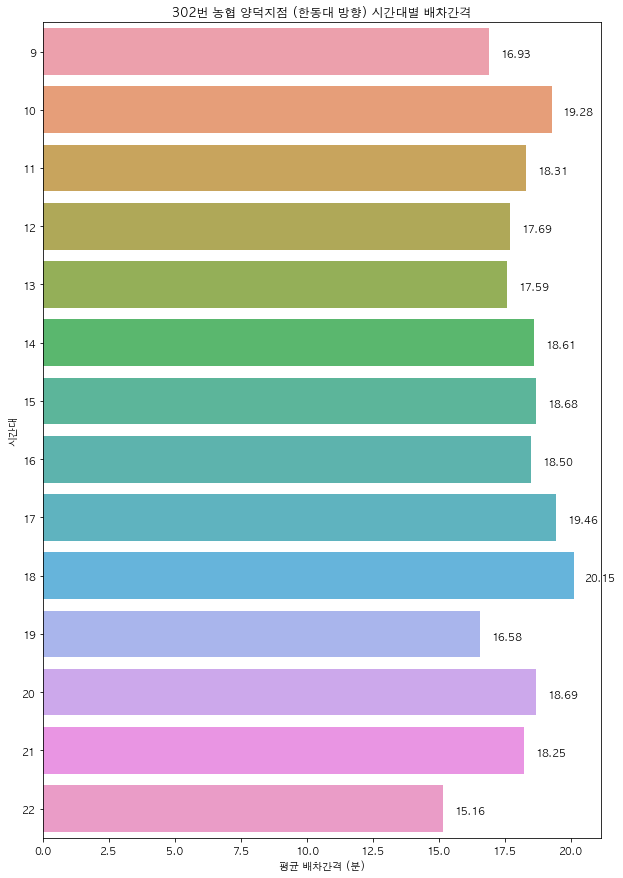

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 그래프 준비
plt.figure(figsize=(10,15))
# hourdata.dtypes
# plt.barh(hourdata.index.astype(str), hourdata['dval'])

barg = sns.barplot(x=hourdata['dval'], y=hourdata.index.astype(str), alpha=0.9, orient='h')

# Label 추가
for p in barg.patches:
    width = p.get_width()
    plt.text(1+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center')

plt.title("302번 농협 양덕지점 (한동대 방향) 시간대별 배차간격")
plt.xlabel("평균 배차간격 (분)")
plt.ylabel("시간대")

plt.show()



------------

# Test Process

In [ ]:
copy = pd.DataFrame(all_datas)
copy.head()

In [ ]:
copy.dropna(subset=["diff"], inplace=True)
copy['dval'] = all_datas.dropna(subset=["diff"])["diff"].dt.seconds.div(60, fill_value=0)
copy.head()

In [ ]:
copy.loc[copy['dval'] > 70].sort_values(by=["dval"]).head()

In [ ]:
copy.loc[copy['dval'] == 0]

In [ ]:
# all Days
print("Number of days:", len(copy.groupby(pd.Grouper(freq='D'))))

In [ ]:
copy.sort_values(['time', 'vehicleno']).loc["2021-10-18"]

In [ ]:
# 빈파일 목록 확인
empty_files = []
for name, data in all_df.items():
    if len(data) == 0:
        empty_files.append(name)
len(empty_files)

In [ ]:
import numpy as np
# 빈파일들에는 null 데이터를 추가하여 다음 시간이 계산이 안되게 처리.
for file in empty_files:
    datetime = pd.to_datetime(file, format="%y%m%d/%H%M%S", errors="coerce", exact=False)
    copy.loc[datetime] = [np.nan for i in range(len(copy.columns))]

In [ ]:
copyr = copy.sort_index()
copyr["diff2"] = copyr.index.to_series().diff()
copyr = copyr[~copyr.vehicleno.shift().isna()].dropna(subset=['filename'])
print(len(copyr))
# copyr.loc['2021-09-14 13:30':'2021-09-14 16:30']

In [ ]:
# all_datas["diff"]
copyr_diffdata = copyr.dropna(subset=["diff"])["diff"].dt.seconds.div(60, fill_value=0)
copyr_diffdata[(copyr_diffdata < 120) & (copyr_diffdata > 2)].describe() # 최대시간을 2시간으로 두어 익일인 경우 무시.

In [ ]:
# Remove diff data if last row doesn't have any information
for item in copyr.index:
    print(copyr.vehicleno.shift().loc[item])
    if pd.isnull(copyr.vehicleno.shift().loc[item]):
        copyr.loc[item, "dval"] = np.nan

In [ ]:
copyr.diff2

In [ ]:
copy

In [ ]:
copy.sort_index().loc['2021-09-14 13:30':'2021-09-14 16:30']

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
copy.sort_index().loc['2021-09-14']

In [ ]:
# Filter all empty files
len(result)

In [ ]:
# https://stackoverflow.com/questions/56057755/extract-all-rows-in-dataframe-having-same-date
for name, group in copy.groupby(pd.Grouper(freq='D')):
    print(name)